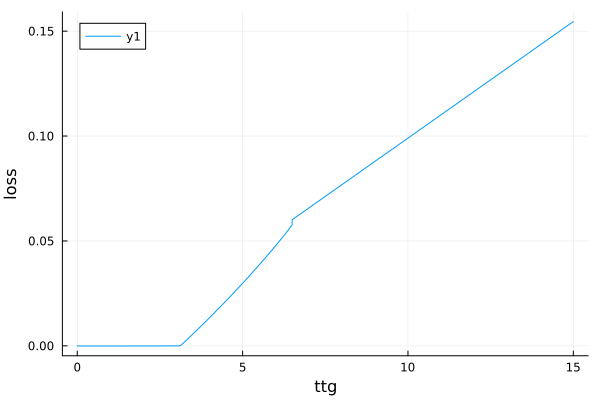

In [9]:
using Plots
using Distributions
using Random
using Printf
using Interpolations

# car parameters
mass=1500.0 #kg
power=80e3 #W
brake_acceleration=8.0 #m/s^2
Cd=0.4 # drag coefficient
A=2.0 # frontal area
min_speed=0.05 #m/s
cost_per_J=1.85/(45e6)#$/J
cost_pers_s=40/(60*60)#$/s

rho=1.2 # air density
time_to_green_distribution=Exponential(3.0)
initial_speed=30.0 #m/s
initial_position=-150.0 #m
safety_distance=0.0 #m
using Interpolations


discretization=500
sampling_count=10000
locations=range(initial_position, stop=0.0, length=discretization)
Strategy=Vector # acceleration at every position step
max_acceleration(v)=min(10.0,power/(v+min_speed))
function clip_acceleration(acceleration::Real,v)
    if v>=initial_speed
        return min(acceleration,0)
    end
    drag_force=0.5*rho*Cd*A*v^2
    return clamp(acceleration,-brake_acceleration,max_acceleration(v))
end

function compute_power(acceleration::Float64,v)
    drag_force=0.5*rho*Cd*A*v^2
    acceleration_force=max(0,acceleration)*mass
    return (drag_force+acceleration_force)*v
end


struct InterpolationTrajectory
    acceleration
    speed
    time
    energy_loss
    time_loss
    time_to_location
    v_end_to_energy_loss
    v_end_to_time_loss
end
speedup_discretization=1000
function compute_raw_trajectory(s::Strategy)
    acceleration=zeros(length(s))
    speed=zeros(length(s))
    time=zeros(length(s))
    speed[1]=initial_speed
    # simulate
    t=0
    energy=0.0
    energy_loss=zeros(length(s))
    time_loss=zeros(length(s))
    for i in 2:length(s)
        time[i]=t
        dt=(locations[i]-locations[i-1])/speed[i-1]
        a=s[i-1]
        distance_to_stop=speed[i-1]^2/(2*brake_acceleration)
        if distance_to_stop>=abs(locations[i])-safety_distance
            a=-Inf
        end
        if speed[i-1]<=min_speed && a<=0
            a=0.0
            acceleration[i-1]=a
            speed[i]=0
            energy_loss[i]=energy_loss[i-1]
            #t=time_to_green-1e-6
            continue
        end
        a=clip_acceleration(a,speed[i-1])
        acceleration[i-1]=a
        time_without_break=(locations[i]-initial_position)/initial_speed
        time_loss[i]=t-time_without_break
        energy+=compute_power(a,speed[i-1])*dt
        energy_without_break=compute_power(0.0,initial_speed)*time_without_break
        energy_loss[i]=energy-energy_without_break
        t+=dt
        speed[i]=speed[i-1]+a*dt
        if speed[i]<=min_speed
            speed[i]=min_speed
        end
    end
    #return RawTrajectory(acceleration,speed,time,energy_loss,time_loss)
    # compute speedup losses
    x=0.0
    t=0.0
    energy=0.0
    speeds=range(min_speed,stop=initial_speed,length=speedup_discretization)
    energy_loss_speedup=zeros(length(speeds))
    time_loss_speedup=zeros(length(speeds))
    dv=(initial_speed-min_speed)/(speedup_discretization-1)
    for i in eachindex(speeds)
        v=speeds[i]
        a=max_acceleration(v)
        dt=dv/a
        x+=v*dt
        t+=dt
        energy+=compute_power(a,v)*dt
        energy_loss_speedup[i]=energy-compute_power(0.0,initial_speed)/initial_speed*x
        time_loss_speedup[i]=t-x/initial_speed
    end
    final_energy_loss=energy_loss_speedup[end]
    final_time_loss=time_loss_speedup[end]
    energy_loss_speedup=final_energy_loss .- energy_loss_speedup
    time_loss_speedup=final_time_loss .- time_loss_speedup

    return InterpolationTrajectory(
        linear_interpolation(locations,acceleration),
        linear_interpolation(locations,speed; extrapolation_bc=Flat()),
        linear_interpolation(locations,time),
        linear_interpolation(locations,energy_loss; extrapolation_bc=Flat()),
        linear_interpolation(locations,time_loss; extrapolation_bc=Flat()),
        linear_interpolation(time,locations; extrapolation_bc=Flat()),
        linear_interpolation(speeds,energy_loss_speedup; extrapolation_bc=Flat()),
        linear_interpolation(speeds,time_loss_speedup; extrapolation_bc=Flat())
    )
end
function RecipesBase.plot(t::InterpolationTrajectory)
    p=plot(locations,t.speed.(locations),label="speed")
    # plot!(p,t.time,t.acceleration,label="acceleration")
    # plot!(p,t.time,locations,label="position")
    plot!(p,xlabel="posiotion",ylabel="speed/acceleration")
    #title!(p,"Losses: E: $(@sprintf("%.2f", sum(t.energy_loss)/1e3)) kJ, t: $(@sprintf("%.2f", sum(t.time_loss))) s")
    return p
end


s=Strategy(-0.01*ones(discretization))
function loss(t::InterpolationTrajectory,time_to_green::Float64)
    switch_location=t.time_to_location(time_to_green)
    energy_loss=t.energy_loss(switch_location)
    time_loss=t.time_loss(switch_location)
    v_end=t.speed(switch_location)
    if switch_location>-0.01
        time_loss=time_to_green-abs(initial_position)/initial_speed
        v_end=0.0
    end
    #add tail loss
    time_loss+=t.v_end_to_time_loss(v_end)
    energy_loss+=t.v_end_to_energy_loss(v_end)
    return time_loss*cost_pers_s+energy_loss*cost_per_J
end
ttgs=rand(time_to_green_distribution,sampling_count)
function loss(s::Strategy)
    t=compute_raw_trajectory(s)
    return sum([loss(t,ttg) for ttg in ttgs])/sampling_count
end
raw_tr=compute_raw_trajectory(s)
#plot(raw_tr) |> display
#display(raw_tr.energy_loss)
#plot(raw_tr) |> display
#println("Loss: $(loss(raw_tr,104.0))")
#println("Loss: $(loss(s))")
@time print("Loss:",loss(s))
loss(raw_tr,4.0)
plot(t->loss(raw_tr,t),0,15, xlabel="ttg", ylabel="loss") |> display
#plot(t->raw_tr.time_to_location(t),0,15) |> display
# plot(t->raw_tr.time_to_location(t)|>raw_tr.speed,0,15, xlabel="t", ylabel="v") |> display
# plot(v->raw_tr.v_end_to_energy_loss(v),0,initial_speed, xlabel="v_speedup", ylabel="energy loss") |> display
# plot(v->raw_tr.v_end_to_time_loss(v),0,initial_speed, xlabel="v_speedup", ylabel="time loss") |> display


In [10]:
using Optim
sol=optimize(loss,s,BFGS();autodiff=:forward)
display(sol)

MethodError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{typeof(loss), Float64}, Float64, 12})

Closest candidates are:
  (::Type{T})(::Real, !Matched::RoundingMode) where T<:AbstractFloat
   @ Base rounding.jl:207
  (::Type{T})(::T) where T<:Number
   @ Core boot.jl:792
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number}
   @ Base char.jl:50
  ...


In [3]:
s_min=sol.minimizer
raw_tr=compute_raw_trajectory(s_min)
plot(raw_tr) |> display

UndefVarError: UndefVarError: `sol` not defined